In [1]:
#importamos librerias
import re
import requests
from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


### cargamos el dataset con de la libreria de tensorflow (imdb_reviews)

In [2]:
tfds.disable_progress_bar()
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
(train_data, test_data) = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC238VC/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC238VC/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC238VC/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
for example, label in train_data.take(5):
  print('text :', example.numpy())
  print('label :', label.numpy())
  # 0 = mala reseña\negativa
  # 1 = buena reseña\positiva

text : b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label : 0
text : b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### creando el codificador de texto (encoder)

In [7]:
VOCAB_SIZE = 5500
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, lebale: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U16')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([ 15, 377,  26])

### creando el modelo

In [10]:
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
])

### compilamos el modelo

In [15]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

### entrenamos el modelo

In [16]:
#como estamos en un problema de calsificacion de texto, se necesita datos de entrenamiento y validacion 
hist = model.fit(train_data, epochs=10, 
          validation_data= test_data,
          validation_steps=35)

Epoch 1/10
391/391 [==============================] - 75s 153ms/step - loss: 0.6240 - accuracy: 0.7090 - val_loss: 0.5602 - val_accuracy: 0.8509
Epoch 2/10
391/391 [==============================] - 58s 148ms/step - loss: 0.5531 - accuracy: 0.7785 - val_loss: 0.5416 - val_accuracy: 0.7429
Epoch 3/10
391/391 [==============================] - 56s 143ms/step - loss: 0.5100 - accuracy: 0.7908 - val_loss: 0.5053 - val_accuracy: 0.7772
Epoch 4/10
391/391 [==============================] - 57s 144ms/step - loss: 0.6313 - accuracy: 0.7125 - val_loss: 0.4859 - val_accuracy: 0.8067
Epoch 5/10
391/391 [==============================] - 57s 144ms/step - loss: 0.5632 - accuracy: 0.7492 - val_loss: 0.4857 - val_accuracy: 0.8295
Epoch 6/10
391/391 [==============================] - 57s 144ms/step - loss: 0.6171 - accuracy: 0.7200 - val_loss: 0.6887 - val_accuracy: 0.5004
Epoch 7/10
391/391 [==============================] - 57s 145ms/step - loss: 0.6230 - accuracy: 0.6670 - val_loss: 0.5532 - val_ac

### evaluacion

In [68]:
test_loss, test_acc = model.evaluate(test_data)
print('perdida : {}'.format(test_loss))
print('exactitud : {}'.format(test_acc))

391/391 [==============================] - 38s 77ms/step - loss: 0.6496 - accuracy: 0.6124
perdida : 0.6496002078056335
exactitud : 0.6123999953269958


### graficamos los resultados

In [66]:
def plot_graf(hist, metrics):
  plt.plot(hist.history[metrics])
  plt.plot(hist.history['val_'+ metrics], '')
  plt.ylabel(metrics) 
  plt.xlabel('Epoch' )
  plt.legend([metrics,'val_'+ metrics])  

(0.0, 1.010083842277527)

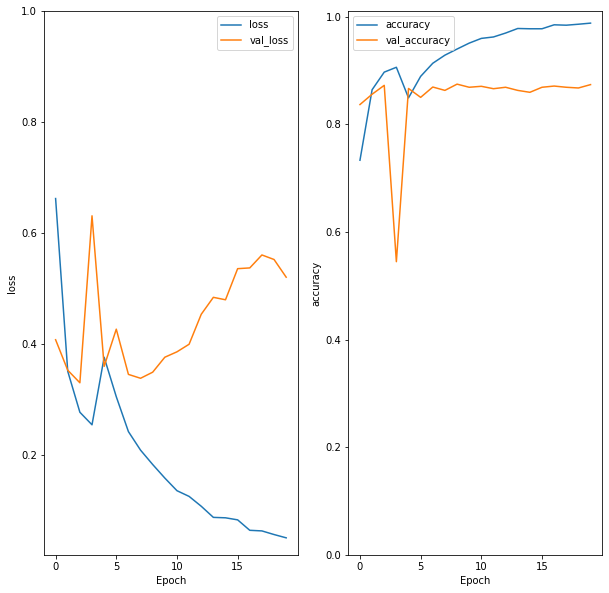

In [67]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plot_graf(hist, 'loss')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graf(hist, 'accuracy')
plt.ylim(0, None)

### predicciones con ejemplos

In [69]:
firts_example = ('The movie was not good. The animation and the graphics were terrible.')
second_example = ('The movie was great. The animation and the graphics were out of the word.')

In [70]:
predictions = model.predict(np.array([second_example]))
print(predictions)
if predictions[0] > 0.5:
  print('reseña positiva')
else:
  print('reseña negativa')


[[0.36876822]]
reseña negativa


El modelo arroja predicciones imprecisas así que, acontinuación se hará otro modelo para mejorar la predicción

### segundo modelo

aplicamos regularización(L2) para bajar el overfiting

In [29]:
from keras import regularizers

In [30]:
model2 = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

### compilando el modelo 2

In [32]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

### entrenando el modelo 2

In [57]:
hist2 = model2.fit(train_data, epochs=20, 
          validation_data= test_data,
          validation_steps=35)

Epoch 1/20
391/391 [==============================] - 61s 155ms/step - loss: 0.0462 - accuracy: 0.9894 - val_loss: 0.5810 - val_accuracy: 0.8629
Epoch 2/20
391/391 [==============================] - 58s 146ms/step - loss: 0.0418 - accuracy: 0.9912 - val_loss: 0.6056 - val_accuracy: 0.8625
Epoch 3/20
391/391 [==============================] - 58s 146ms/step - loss: 0.0524 - accuracy: 0.9870 - val_loss: 0.6259 - val_accuracy: 0.8661
Epoch 4/20
391/391 [==============================] - 58s 147ms/step - loss: 0.0404 - accuracy: 0.9914 - val_loss: 0.5854 - val_accuracy: 0.8616
Epoch 5/20
391/391 [==============================] - 60s 153ms/step - loss: 0.0411 - accuracy: 0.9909 - val_loss: 0.6453 - val_accuracy: 0.8665
Epoch 6/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0296 - accuracy: 0.9948 - val_loss: 0.6852 - val_accuracy: 0.8679
Epoch 7/20
391/391 [==============================] - 59s 150ms/step - loss: 0.0352 - accuracy: 0.9924 - val_loss: 0.6786 - val_ac

### evaluando el modelo 2

In [58]:
test_loss, test_acc = model2.evaluate(test_data)
print('perdida : {}'.format(test_loss))
print('exactitud : {}'.format(test_acc))

391/391 [==============================] - 30s 76ms/step - loss: 0.7573 - accuracy: 0.8659
perdida : 0.7573347687721252
exactitud : 0.865880012512207


### graficando el modelo 2

In [59]:
def plot_graf(hist2, metrics):
  plt.plot(hist2.history[metrics])
  plt.plot(hist2.history['val_'+ metrics], '')
  plt.ylabel(metrics) 
  plt.xlabel('Epoch' )
  plt.legend([metrics,'val_'+ metrics])  


(0.0, 1.0051570773124694)

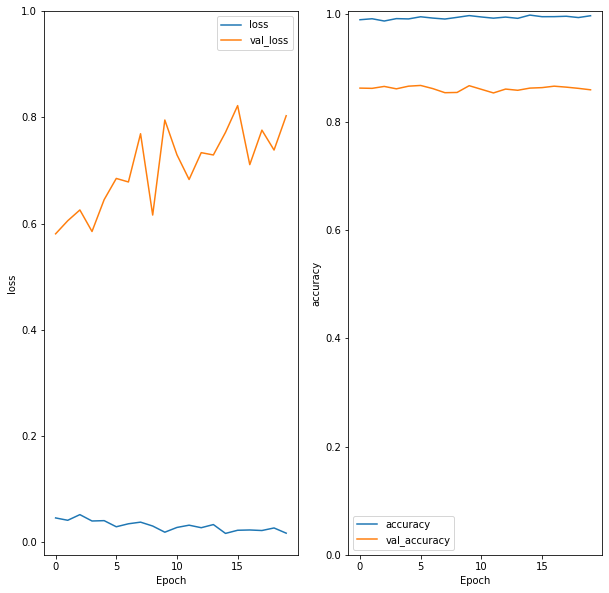

In [60]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plot_graf(hist2, 'loss')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graf(hist2, 'accuracy')
plt.ylim(0, None)

### predicciones con ejemplos de prueba

In [61]:
firts_example = ('The movie was not good. The animation and the graphics were terrible.')
second_example = ('The movie was great. The animation and the graphics were out of the word.')

In [72]:
predictions = model2.predict(np.array([firts_example]))
print(predictions)
if predictions[0] >= 0.5:
  print('reseña positiva')
else:
  print('reseña negativa')

[[0.47567087]]
reseña negativa


## Conclusión éste modelo de análisis de sentimientos, arroja valores suficientemete precisos, con respecto a la prediccion, tomando como datos los ejemplos de prueba. 